# SPAM Detection

The dataset is an SMS Spam Collection or a set of SMS tagged messages which contains a set of SMS messages in Engish of 5,574 messages.It has v1 which depicts if its ham(usefull) or spam(unwanted)

# Importing libraries 

In [1]:
import pandas as pd
import numpy as np
import string
import nltk

from wordcloud import WordCloud, STOPWORDS #importing word cloud
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error # the main evaluation metric
from sklearn import metrics
from sklearn.model_selection import train_test_split #for splitting the data

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv(r'C:\Users\91901\Documents\Python\spam.csv',encoding='ISO 8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
#display the missing values in our dataset
missing_data = df.isnull()
missing_data.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,False,False,True,True,True
1,False,False,True,True,True
2,False,False,True,True,True
3,False,False,True,True,True
4,False,False,True,True,True


In [4]:
#count the number of missing value for each column
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")    

v1
False    5572
Name: v1, dtype: int64

v2
False    5572
Name: v2, dtype: int64

Unnamed: 2
True     5522
False      50
Name: Unnamed: 2, dtype: int64

Unnamed: 3
True     5560
False      12
Name: Unnamed: 3, dtype: int64

Unnamed: 4
True     5566
False       6
Name: Unnamed: 4, dtype: int64



In [5]:
#print ham and spam count
y = df['v1']
print (y.value_counts())

ham     4825
spam     747
Name: v1, dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.7+ KB


We'll change ham to 0 and spam to 1 and update it in the column

In [7]:
df['v1'][df['v1']=='ham']=0
df['v1'][df['v1']=='spam']=1

In [8]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,0,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,0,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,0,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Feature engineering

In [9]:
#combining the unnamed columns to v2 and forming a new column 
#to basically get the whole message
df.fillna(' ',inplace = True)
df['total_mess'] = df['v2'] + df['Unnamed: 2'] + df['Unnamed: 3'] + df['Unnamed: 4'] #combine the columns 
df['total_mess']=df['total_mess'].str.strip() #removing the white spaces
df['total_mess'] = df['total_mess'].str.lower() # convert to lower case

#removing punctuation
p = string.punctuation
table = str.maketrans('','',p)
df['total_mess'] = df['total_mess'].apply(lambda x:x.translate(table))

#tokenising each message
df['tokenwd']=df.apply(lambda x: x['total_mess'].split(' '),axis=1)

#removing stop words
stopwords = set(STOPWORDS)
df['cleanedt'] = df.apply(lambda x: [word for word in x['tokenwd'] if word not in stopwords],axis=1)

stemming is the concept of converting words to their root words e.g. run, running , ran ,is running, all have a root word run. Stemming turns words to their root words. We use porter stemmer from nltk module for this purpose.

In [10]:
#stemming 
ps = nltk.PorterStemmer()
df['stemed'] = df.apply(lambda x: [ps.stem(word) for word in x['cleanedt']],axis = 1)

#removing simgle letter
df['final_t'] = df.apply(lambda x: ' '.join([word for word in x['stemed']if len(word) > 1]),axis=1)

So let's view our engineered data set

In [11]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,total_mess,tokenwd,cleanedt,stemed,final_t
0,0,"Go until jurong point, crazy.. Available only ...",,,,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...",go jurong point crazi avail bugi great world l...
1,0,Ok lar... Joking wif u oni...,,,,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]",ok lar joke wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,,,,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...",free entri wkli comp win fa cup final tkt 21st...
3,0,U dun say so early hor... U c already then say...,,,,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]",dun say earli hor alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",,,,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...",nah dont think goe usf live around though


In [12]:
#dropping every column except what we need , v1 and final_t
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4','total_mess','tokenwd','cleanedt','stemed'],axis=1).head()

,v1,v2,final_t
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi great world l...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt 21st...
3,0,U dun say so early hor... U c already then say...,dun say earli hor alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


# Time for Prediction 

setting our predictors and prediction variable

In [13]:
predictor = df['final_t']
cv = CountVectorizer()
x = cv.fit_transform(predictor).toarray()

In [14]:
y=df['v1']
le = LabelEncoder()
y = le.fit_transform(y)

Splitting our dataset for training and validation

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)#splitting our dataset
print ('Train set:', X_train.shape,  y_train.shape) #count of training set
print ('Test set:', X_test.shape,  y_test.shape) #count of test set

Train set: (4457, 8131) (4457,)
Test set: (1115, 8131) (1115,)


# Start of with naive bayes

In [16]:
from sklearn.naive_bayes import GaussianNB
bayes_classifier = GaussianNB()
bayes_classifier.fit(X_train, y_train)
y_val = bayes_classifier.predict(X_test)
print("-----------------NAIVE BAYES---------------------")
print("Train set Accuracy: ", metrics.accuracy_score(y_train, bayes_classifier.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_val))
mse = mean_squared_error(y_val, y_test)
print("Validation for naive bayes : {}".format(mse))

-----------------NAIVE BAYES---------------------
Train set Accuracy:  0.9284271931792686
Test set Accuracy:  0.8717488789237668
Validation for naive bayes : 0.12825112107623318


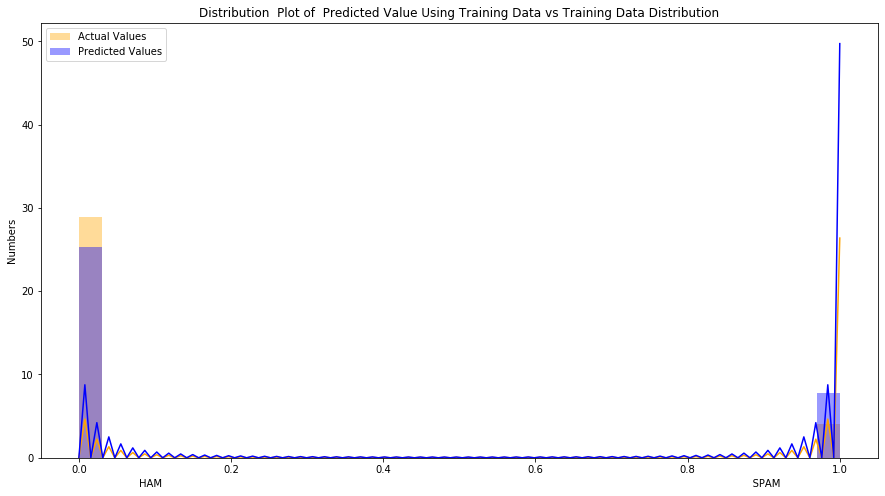

In [17]:

def DistributionPlot(OrangeFunction, BlueFunction, OrangeName, BlueName, Title):
    """This function helps us visualize and to compare the ham's and spam's with resoect to the training and validation sets"""
    width = 15
    height = 8
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(OrangeFunction, hist=True, color="orange", label=OrangeName)
    ax2 = sns.distplot(BlueFunction, hist=True, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('HAM                                                                                                                                                                                             SPAM')
    plt.ylabel('Numbers')
    plt.legend(loc='upper left') 

    plt.show()
    plt.close()

Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_test, y_val, "Actual Values", "Predicted Values", Title)

Our goal is to match the orange and blue peaks as much as possible

# Let's try decision tree regressor

In [18]:
from sklearn.tree import DecisionTreeClassifier
DTree = DecisionTreeClassifier(criterion="entropy", max_depth = 8)
DTree.fit(X_train,y_train)
y_val = DTree.predict(X_test)
from sklearn import metrics
print("-----------------DECISION TREE CLASSIFIER---------------------")
print("Train set Accuracy: ", metrics.accuracy_score(y_train, DTree.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_val))
mse = mean_squared_error(y_val, y_test)
print("Validation for DTR : {}".format(mse))

-----------------DECISION TREE CLASSIFIER---------------------
Train set Accuracy:  0.9504150774063271
Test set Accuracy:  0.947085201793722
Validation for DTR : 0.05291479820627803


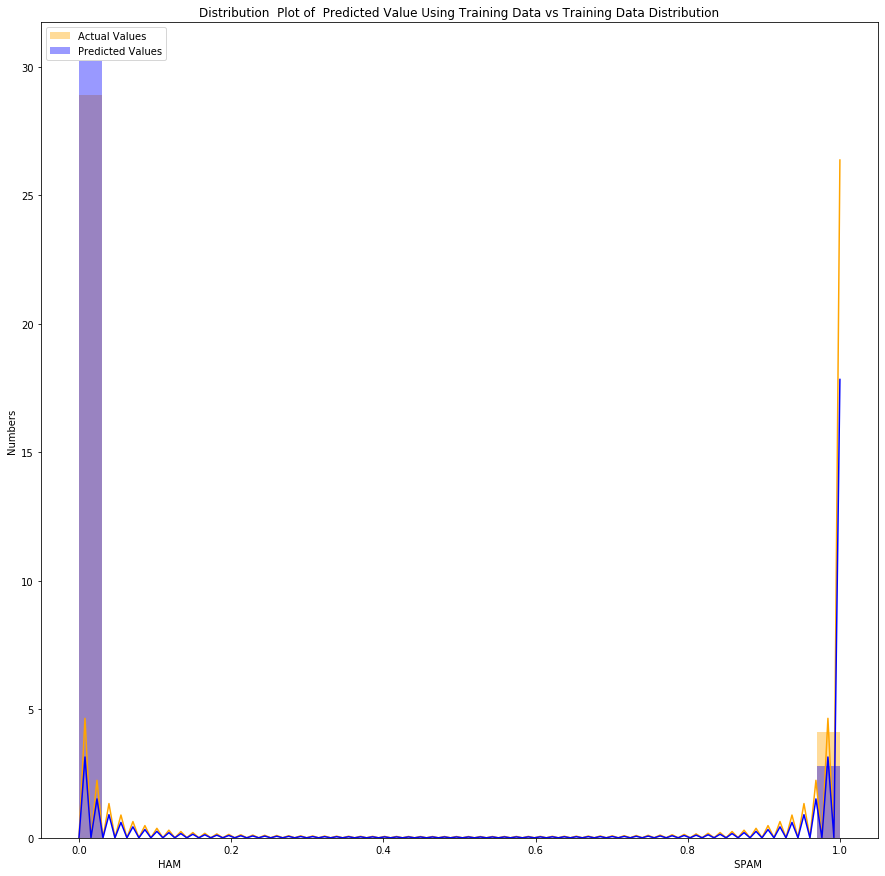

In [19]:
def DistributionPlot(OrangeFunction, BlueFunction, OrangeName, BlueName, Title):
    width = 15
    height = 15
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(OrangeFunction, hist=True, color="orange", label=OrangeName)
    ax2 = sns.distplot(BlueFunction, hist=True, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('HAM                                                                                                                                                                                 SPAM')
    plt.ylabel('Numbers')
    plt.legend(loc='upper left') 

    plt.show()
    plt.close()

Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_test, y_val, "Actual Values", "Predicted Values", Title)

# Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=1, solver='liblinear').fit(X_train,y_train)
y_val = LR.predict(X_test)
from sklearn import metrics
print("------------------LOGISTIC REGRESSION---------------------")
print("Train set Accuracy: ", metrics.accuracy_score(y_train, LR.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_val))
mse = mean_squared_error(y_val, y_test)
print("Validation for LR : {}".format(mse))

------------------LOGISTIC REGRESSION---------------------
Train set Accuracy:  0.9959614090195199
Test set Accuracy:  0.989237668161435
Validation for LR : 0.010762331838565023


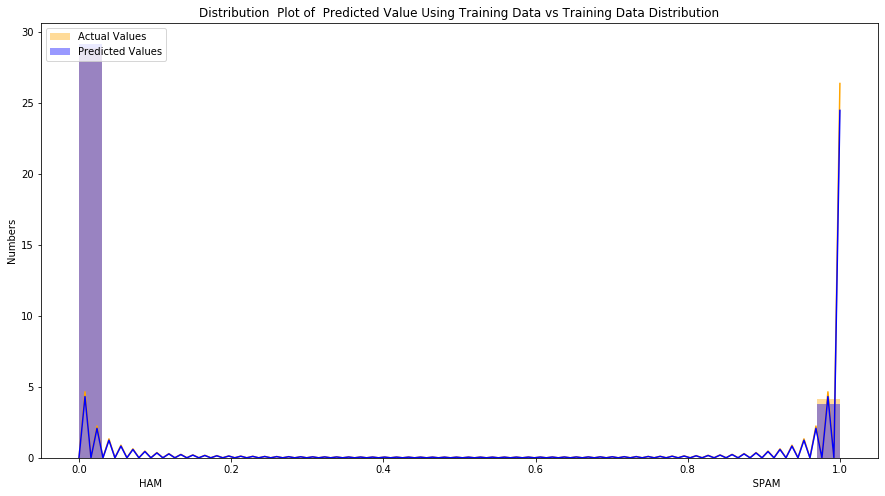

In [21]:
def DistributionPlot(OrangeFunction, BlueFunction, OrangeName, BlueName, Title):
    """This function helps us visualize and to compare the ham's and spam's with resoect to the training and validation sets"""
    width = 15
    height = 8
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(OrangeFunction, hist=True, color="orange", label=OrangeName)
    ax2 = sns.distplot(BlueFunction, hist=True, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('HAM                                                                                                                                                                                             SPAM')
    plt.ylabel('Numbers')
    plt.legend(loc='upper left') 

    plt.show()
    plt.close()

Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_test, y_val, "Actual Values", "Predicted Values", Title)

Hence logistic regression is the best algorithm for spam detection